In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from itertools import chain, combinations

import seaborn
seaborn.set()

In [2]:
def literal_eval(x):
    return x.strip("[]").replace("'","").split(", ")

In [218]:
data = pd.read_csv(
        'movies10.csv.gz',
        index_col=0,
        compression='gzip',
        converters={'genres': lambda x: literal_eval(x), 'directors': lambda x: literal_eval(x)} # https://stackoverflow.com/a/53742380
    )

In [215]:
data_explode = data.explode('genres')
data_explode

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
tconst,,,,,,,
tt0100267,Nobat e Asheghi,1995,75,Drama,6.4,216.0,[nm0538532]
tt0100267,Nobat e Asheghi,1995,75,Romance,6.4,216.0,[nm0538532]
tt0103340,Life for Life: Maximilian Kolbe,2006,90,Biography,6.3,355.0,[nm0953130]
tt0103340,Life for Life: Maximilian Kolbe,2006,90,Drama,6.3,355.0,[nm0953130]
tt0105298,Running Wild,1995,94,Drama,5.6,396.0,[nm0572114]
...,...,...,...,...,...,...,...
tt9905412,Ottam,2019,120,Drama,6.3,568.0,[nm10533890]
tt9906644,Manoharam,2019,122,Comedy,6.8,851.0,[nm7011994]
tt9906644,Manoharam,2019,122,Drama,6.8,851.0,[nm7011994]


In [270]:
# The average rating based on genre
genre_explode = data_explode.groupby(['genres']).agg({'genres':['count'], 'averageRating':['mean']}).reset_index()
genre_explode.columns = genre_explode.columns.droplevel(1)
genre_explode.columns.values[1] = 'count'
# genre_explode

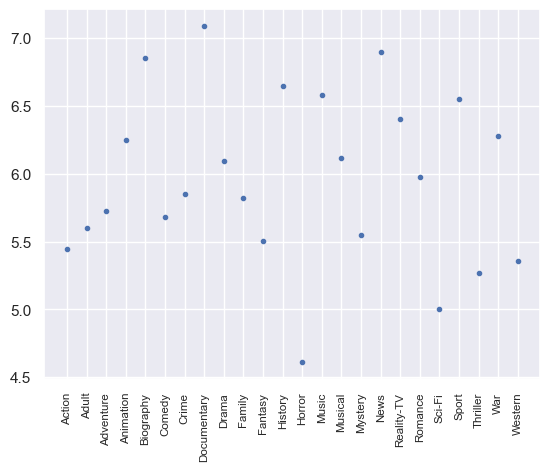

In [194]:
# plt.xticks(rotation=25)
# plt.bar(genre_explode.genres, genre_explode.averageRating)
plt.plot(genre_explode.genres, genre_explode.averageRating, 'b.')
plt.xticks(rotation=90, fontsize = 'x-small')
plt.show()

In [293]:
# The average rating based on runtime
runtime_explode = data_explode.groupby(['runtimeMinutes']).agg({'primaryTitle':['first'], 'runtimeMinutes':['count'], 'averageRating':['mean']}).reset_index()
runtime_explode.columns = runtime_explode.columns.droplevel(1)
runtime_explode.columns.values[2] = 'count'
# runtime_explode

In [294]:
runtime_range = runtime_explode.groupby(pd.cut(runtime_explode['runtimeMinutes'], np.arange(20,841,20))).agg({'count':['sum'], 'runtimeMinutes':['count'], 'averageRating':['mean']}).reset_index()
# runtime_range.dropna()

In [272]:
# average rating based on year
year_explode = data_explode.groupby(['startYear']).agg({'startYear':['count'], 'averageRating':['mean']}).reset_index()
year_explode.columns = year_explode.columns.droplevel(1)
year_explode.columns.values[1] = 'count'
# year_explode

In [307]:
# highest rated genre for each year
year_genre_explode = data_explode.groupby(by=['startYear', 'genres']).agg({'genres':['count'], 'averageRating':['mean']}).reset_index()
year_genre_explode.columns = year_genre_explode.columns.droplevel(1)
year_genre_explode.columns.values[2] = 'count'
# year_genre_explode.loc[year_genre_explode.groupby('startYear')['averageRating'].idxmax()] # https://stackoverflow.com/a/53842377

In [304]:
# same as above but filtered
filtered = year_genre_explode[year_genre_explode['count'] > 5]
filtered = filtered[filtered['genres'] != 'Documentary']
filtered = filtered[filtered['genres'] != 'Biography']
# filtered.loc[filtered.groupby('startYear')['averageRating'].idxmax()]

In [252]:
# exloding based on director and finding their highest rated movie
dir_explode = data.explode('directors')
# dir_explode.loc[dir_explode.groupby('directors')['averageRating'].idxmax()].sort_values('averageRating')

In [253]:
# creating a powerset from the list of genres
# https://stackoverflow.com/a/64486029
# genres are already sorted
new_df = data.join(data['genres'].explode().rename('target'))
new_df['genres'] = [[a for a in x if a != y] 
                       for x,y in zip(new_df['genres'], new_df['target'])]
new_df = new_df[new_df['genres'].str.len() != 0].reset_index()
new_df = new_df.drop('target', axis=1)
# new_df

In [254]:
# creating a powerset from the list of genres and directors
new_df_directors = new_df.join(new_df['directors'].explode().rename('target'))
new_df_directors['directors'] = [[a for a in x if a != y] 
                               for x,y in zip(new_df_directors['directors'], new_df_directors['target'])]
new_df_directors = new_df_directors[new_df_directors['directors'].str.len() != 0].reset_index()
new_df_directors = new_df_directors.drop('target', axis=1)
# new_df_directors

In [257]:
# The average rating based on genre
res = new_df.groupby(new_df['genres'].map(tuple)).agg({'genres':['count'], 'averageRating':['mean']}).reset_index()
res.columns = res.columns.droplevel(1)
res.columns.values[1] = 'count'
res = res[res['count'] > 10]
# res.sort_values(by=['averageRating'])

In [265]:
# average rating based on year
df = new_df.groupby(['startYear']).agg({'startYear':['count'], 'averageRating':['mean']}).reset_index()
df.columns = df.columns.droplevel(1)
df.columns.values[1] = 'count'
df.columns.values[2] = 'averageRating1'

In [305]:
# finding the difference in ratings from two different techniques
df['averageRating2'] = year_explode['averageRating']
df['ratingDiff'] = abs(df['averageRating1'] - df['averageRating2'])
df

,startYear,count,averageRating1,averageRating2,ratingDiff
0,1995,213,5.874648,5.846304,0.028344
1,1996,266,5.963910,5.975873,0.011963
2,1997,295,5.933220,5.958689,0.025469
3,1998,266,5.975188,5.964242,0.010946
4,1999,273,5.873626,5.909777,0.036150
5,2000,339,5.877286,5.906219,0.028933
6,2001,309,5.848544,5.855467,0.006923
7,2002,344,5.947674,5.989737,0.042063
8,2003,331,5.796677,5.848878,0.052201
9,2004,307,5.933225,6.024433,0.091208


In [268]:
# year_genre_df = new_df.groupby(by=['startYear', 'genres']).agg({'genres':['count'], 'averageRating':['mean']}).reset_index()
# year_genre_explode.columns = year_genre_explode.columns.droplevel(1)
# year_genre_explode.columns.values[2] = 'count'
# year_genre_explode